# Processing for Scanning Microphone



Once we get our audio recording, we need postprocessing to know when the CNC microphone as "stopped", and at which point it stopped. We __do not__ want to analyze audio while moving, as the CNC control is loud and we have no location information.

In [6]:
!pip install librosa > /dev/null
!pip install plotly > /dev/null
import librosa
import numpy as np
from matplotlib import pyplot as plt
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
%matplotlib inline

You only need to mount the google colab drive if you want to access sound samples stored in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Analyzing Simple Frequency

Secibd test consisted of using the __TAZ LULZBOT 5__ recorded with the small microphone Science Center 102. The small microphone attaches through the audio jack on the desktop computer. The sound was emitted through an Apple Airpod connected through the audio jack as well, taped to the baseplate to keep it secured. Sound was played for one hour with frequency $2000$ Hz using the command:

```bash
play -n -c1 synth 3600 sine 2000
```

Scan Parameters:

* (0, 0) to (100, 100)
* around 2cm vertical distance between sound source and microphone
* 1 second record time at each point
* resolution of 2 for both $x$ and $y$
* Only capturing sound when the motor is __not__ moving

In this test, we moved in the pattern

```
51  102  ...  2601
.   .    ...   .
.   .    ...   .
.   .    ...   .
2   53   ...  2551
1   52   ...  2550
```

Using these parameters, we will sample a total of $51 \cdot 51$ points.

### Data Format

Since we have now been able to control the CNC machine through python, we now have already segmented out each of the sampled locations in code. Therefore, the results of one scan will be stored in folder `<int(time.time())>`, and each sound clip in that folder will look like `<x>_<y>_<z>.wav`. We will want a function that preprocesses each separate audio file and returns our analysis as well as the $(x, y, z)$ spatial coordinate so we can combine all of these measurements together at the end.

In [1]:
import glob
import os
import sys

In [4]:
sample_files = glob.glob("/home/robocup/hoffman/scanning-microphone/data/1540965226/*.wav")
len(sample_files)

2601

Let's just load one of these into memory as a sanity check before we process them all.

In [14]:
y, sr = librosa.core.load(sample_files[0], sr=None)
print('Audio Waveform shape: ', y.shape)
print('Sampling Rate: ', sr)
n_seconds = y.shape[0] / sr

Audio Waveform shape:  (43008,)
Sampling Rate:  44100


In [25]:
fft = librosa.core.stft(y)
fft_mag = np.abs(fft)
print(fft.shape)
# Prints out bin number to frequency
print(librosa.core.fft_frequencies())

(1025, 85)
[0.00000000e+00 1.07666016e+01 2.15332031e+01 ... 1.10034668e+04
 1.10142334e+04 1.10250000e+04]


Plotting the actual spectrogram is usually pretty helpful. Since we played the audio signal at 2000 Hz we see a large band there and a faint band at the harmonic, most likely due to the fact that the speaker used as an Apple Airpod and hardware errors.

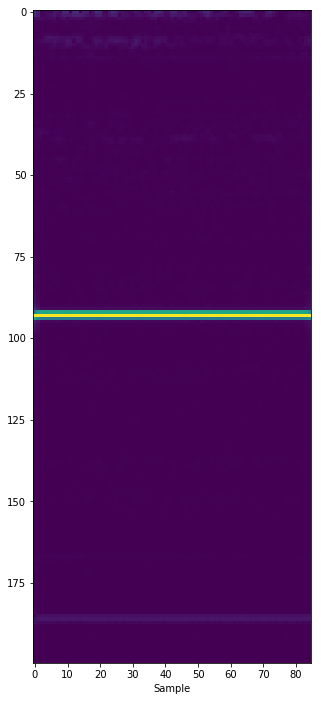

In [26]:
fig = plt.figure(figsize=(15, 12))
plt.xlabel('Sample')
plt.imshow(fft_mag[:200])
plt.show()

The larger hump there is when the motor has to scan more distance to get to the start of the next row.

In [61]:
print("Freq at bin 80: ", librosa.core.fft_frequencies()[185])
print("Freq at bin 100: ", librosa.core.fft_frequencies()[187])

Freq at bin 80:  1991.8212890625
Freq at bin 100:  2013.3544921875


Therefore, we can first see the amplitude changes between different samples at the frequency bins 80-100. We can just directly take the mean of these bins in our absolute valued fourier transform. Let's actually make a function to do this.

In [62]:
def amplitude_check(fname, start_bin, end_bin):
    """Gets the averaged amplitudes from start_bin to end_bin in the fourier transform"""
    y, sr = librosa.core.load(fname, sr=None)
    # print('Audio Waveform shape: ', y.shape)
    # print('Sampling Rate: ', sr)
    fft = librosa.core.stft(y)
    fft_mag = np.abs(fft)
    
    # Actually take the 
    average_binned_mag = fft_mag[start_bin:end_bin, :].mean()
    return average_binned_mag

In [63]:
def file2coords(fname):
    """Converts a file name to coordinates. Should be in the format
        <folder>/<x>_<y>_<z>.wav
    """
    _, name = os.path.split(fname)
    x, y, z = os.path.splitext(name)[0].split('_')
    x = float(x)
    y = float(y)
    z = float(z)
    return x, y, z

In [64]:
# store an array of tuples (x, y, amplitude)
ampdata = []
for index, sfname in enumerate(sample_files):
    if index % 500 == 0:
        print("Processed {} samples".format(index))
    x, y, _ = file2coords(sfname)
    amp = amplitude_check(sfname, 185, 187)
    ampdata.append((x, y, amp))

Processed 0 samples
Processed 500 samples
Processed 1000 samples
Processed 1500 samples
Processed 2000 samples
Processed 2500 samples


## Generating a Heatmap

The real test is to generate a heatmap of frequency strengths, with each point in 3D space scanned and analyzed. We will use the previous code to split the recorded sample into each of the separate points, and then plot the magnitude of certain frequencies on a 2D plot.

__There's probably a much better way to turn the scan into a matrix. Haven't leetcoded enough__

In [65]:
# Get all of the unique x and y indices that could happen in our scan
x_indices = sorted(list(set([a[0] for a in ampdata])))
y_indices = sorted(list(set([a[1] for a in ampdata])))

# Now make a map of tuples to the amplitude value
ampmap = {}
for x, y, amp in ampdata:
    ampmap[(x, y)] = amp

# Turn it back into a numpy array
ampmat = np.zeros((len(x_indices), len(y_indices)))
for idx, x in enumerate(x_indices):
    for idy, y in enumerate(y_indices):
        ampmat[idx][idy] = ampmap[(x, y)]

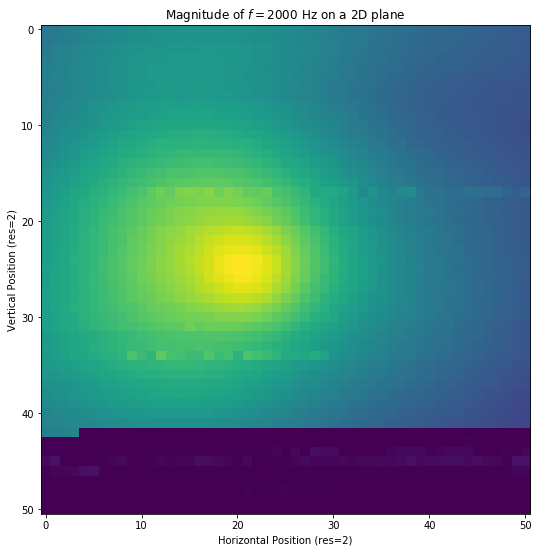

In [66]:
fig = plt.figure(figsize=(9,9))
plt.imshow(ampmat)
plt.xlabel('Horizontal Position (res=2)')
plt.ylabel('Vertical Position (res=2)')
plt.title('Magnitude of $f = 2000$ Hz on a 2D plane')
plt.show()

### Generating a Heatmap for 3D scans

We can do the exact same thing for 3D scans. However, now we are going to have a $z$ axis element. We'll just print out slices of the $z$ axis element for now. We can consider using 3D visualizations with seaborn or matplotlib later but those are usually pretty difficult to decipher.

In [124]:
sample_files_3d = glob.glob("/home/robocup/hoffman/scanning-microphone/data/1541048727/*.wav")

In [125]:
ampdata3D = []
for index, sfname in enumerate(sample_files_3d):
    if index % 500 == 0:
        print("Processed {} samples".format(index))
    x, y, z = file2coords(sfname)
    amp = amplitude_check(sfname, 185, 187)
    ampdata3D.append((x, y, z, amp))

Processed 0 samples
Processed 500 samples
Processed 1000 samples
Processed 1500 samples
Processed 2000 samples
Processed 2500 samples
Processed 3000 samples
Processed 3500 samples
Processed 4000 samples
Processed 4500 samples
Processed 5000 samples
Processed 5500 samples
Processed 6000 samples
Processed 6500 samples
Processed 7000 samples
Processed 7500 samples


In [126]:
# Get all of the unique x and y indices that could happen in our scan
x_indices = sorted(list(set([a[0] for a in ampdata3D])))
y_indices = sorted(list(set([a[1] for a in ampdata3D])))
z_indices = sorted(list(set([a[2] for a in ampdata3D])))
# Now make a map of tuples to the amplitude value
ampmap3D = {}
for x, y, z, amp in ampdata3D:
    ampmap3D[(x, y, z)] = amp

# Turn it back into a numpy array
ampmat3D = np.zeros((len(x_indices), len(y_indices), len(z_indices)))
for idx, x in enumerate(x_indices):
    for idy, y in enumerate(y_indices):
        for idz, z in enumerate(z_indices):
            ampmat3D[idx][idy][idz] = ampmap3D[(x, y, z)]

We will plot each slice corresponding to each $z$ value in one plot. In this specific case, we scanned a $11 \times 11 \times 11$ cube so we can arrange this into $3 \times 4$ grid. First for fun we can slice by the $x$ coordinate and see slices of the $yz$ plane.

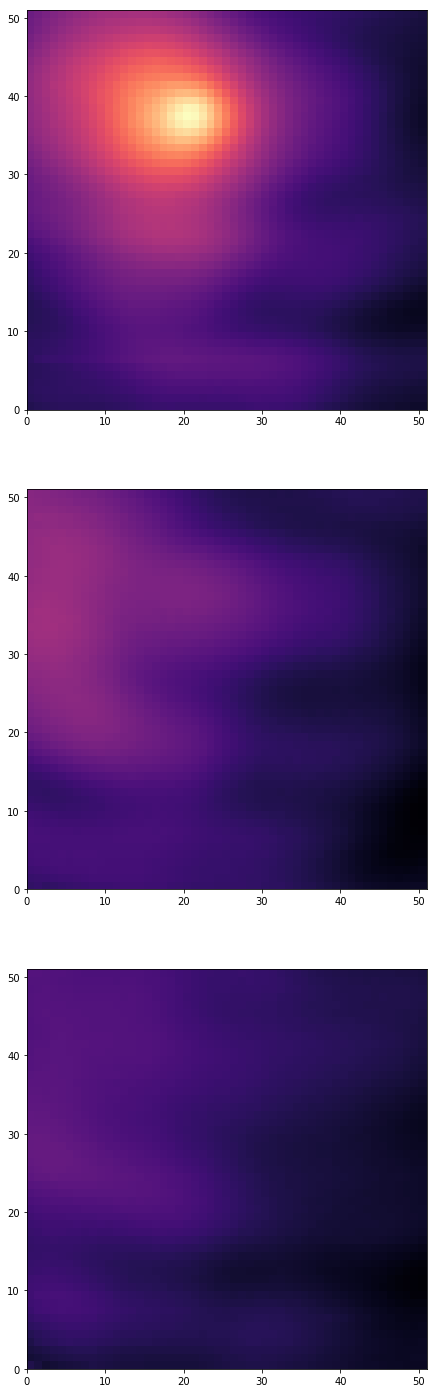

In [134]:
fig = plt.figure(figsize=(11,25))
for index in range(len(z_indices)):
    plt.subplot(len(z_indices),1, index + 1)
    plt.pcolor(ampmat3D[:,:,index], vmin=ampmat3D.min(), vmax=ampmat3D.max(), cmap='magma')
    plt.gca().set_aspect('equal', adjustable='box')
plt.show()